# Calibration and Optimization with Spatially-varying Data

_written by Jaren N. Ashcraft_

Note that this demo is in progress, and as such does not appear on katsu.readthedocs.io. 

To meet the challenge of spatially-resolved Mueller polarimeter measurements, we need to be able to calibrate the polarimeter on a pixel-by-pixel basis. This eliminates one of the greatest sources of averaging down uncertainty in the measurement of a devices Mueller matrix, but is nonetheless important for precision polarization aberration measurement.

Here we aim to leverage Katsu's ability to do spatially-broadcasted calculations to try and calibrate spatial anisotropies in the Dual-rotating-retarder Mueller Polarimeter. This is done entirely in simulation for a demonstration, but we hope to demonstrate this in the laboratory as well. 

Truly performing this calibration on a pixel-by-pixel basis is a high dimenisonal problem. However, we can reduce the dimensionality of the spatial anisotropy by expressing the retardance of the waveplates as a basis expansion.

$$\delta(r, \theta)_{PSG/PSA} = \sum_{i=0}^N a_{i} Z_{i} (r, \theta)$$

Here, we will fit to coefficients $a_i$ of a polynomial $Z_i$ basis. The convenience of expressing the retardance in a functional form in polar coordinates is because we can rotate them quite trivially. For example, if the polarization state generator is rotated an angle $\phi$, the basis expansion changes very simply.

$$\delta(r, \theta + \phi)_{PSG} = \sum_{i=0}^N a_{i} Z_{i} (r, \theta + \phi)$$

Below, we demonstrate such a rotation using _prysm_'s helpful library of polynomials.

In [4]:
import matplotlib.pyplot as plt

from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.polynomials import noll_to_nm, zernike_nm_sequence, sum_of_2d_modes
from prysm.geometry import circle

from katsu.mueller import (
    linear_diattenuator,
    linear_retarder
)

from katsu.katsu_math import np, set_backend_to_jax

# Just a plotting macro
def plot_square(x,n=4,vmin=None,vmax=None):
    k = 1
    plt.figure(figsize=[10,10])
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n,k)
            plt.imshow(x[..., i, j], vmin=vmin, vmax=vmax, cmap='RdBu_r')
            plt.colorbar()
            k += 1
    plt.show()

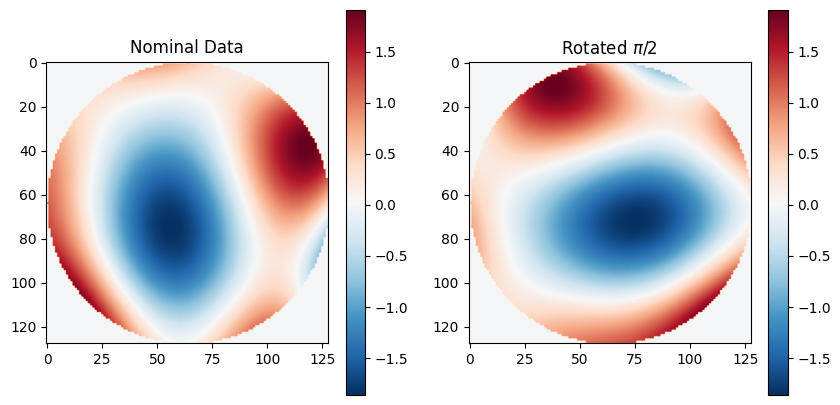

In [7]:
ROTATION_ANGLE = np.pi / 2

# set up coordinates
x, y = make_xy_grid(128, diameter=1)
r, t = cart_to_polar(x, y)

# set up Zernike polynomial basis
nms = [noll_to_nm(i) for i in range(1,37)]
basis = list(zernike_nm_sequence(nms, r, t))
basis_rotated = list(zernike_nm_sequence(nms, r, t + ROTATION_ANGLE))

# generate the data
A = circle(0.5, r)
coeffs = np.random.random(len(basis))
data = sum_of_2d_modes(basis, coeffs)
data_rotated = sum_of_2d_modes(basis_rotated, coeffs)

# plot the data
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Nominal Data')
plt.imshow(data * A, cmap='RdBu_r')
plt.colorbar()
plt.subplot(122)
plt.title('Rotated '+r'$\pi/2$')
plt.imshow(data_rotated * A, cmap='RdBu_r')
plt.colorbar()
plt.show()

A simple constant to the addition accomplishes the rotation. Next, we show how to apply spatially-varying data to `Katsu` linear retarders

In [27]:
scale = 100
NOMINAL_RETARDANCE = np.pi / 4
NOMINAL_ANGLE = 0
coeffs_angle = np.random.random(len(basis)) / scale
coeffs_retardance = np.random.random(len(basis)) / scale

# Use prysm to construct array
angle = sum_of_2d_modes(basis, coeffs_angle) * A
retardance = sum_of_2d_modes(basis, coeffs_retardance) * A

# A quarter-wave plate with error
psg_ret = linear_retarder(NOMINAL_ANGLE + angle, NOMINAL_RETARDANCE + np.pi/4 + retardance, shape=basis[0].shape)

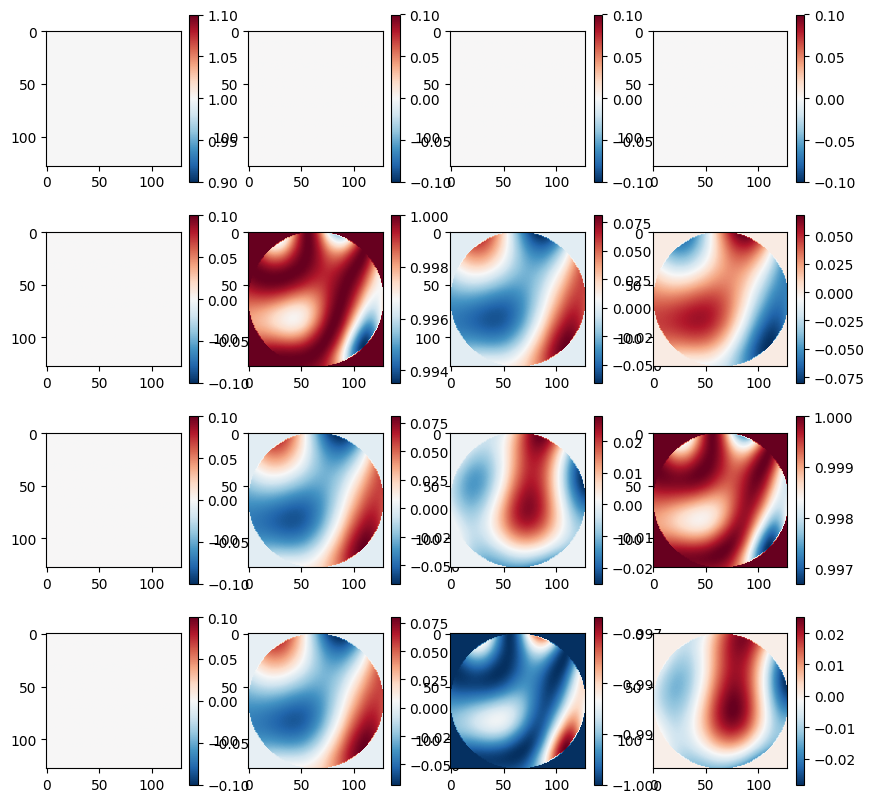

In [28]:
vlim = None
plot_square(psg_ret, n=4, vmin=vlim, vmax=vlim)

Now let's apply a rotation, and we see a fairly substantial change in the Mueller Matrix! Note that the two inner on-diagonal elements have switched.

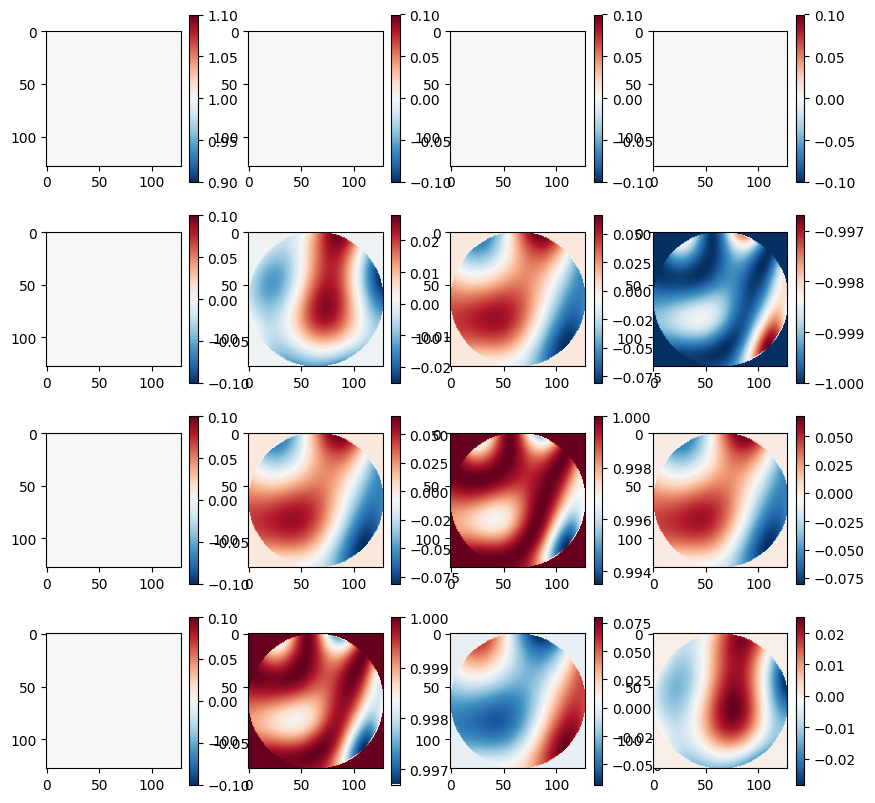

In [29]:
ROTATION = np.pi / 4

psg_ret_rotated = linear_retarder(NOMINAL_ANGLE + ROTATION + angle, NOMINAL_RETARDANCE + np.pi/4 + retardance, shape=basis[0].shape)

plot_square(psg_ret_rotated, n=4, vmin=vlim, vmax=vlim)

Next we construct a forward model with some spatially-varying retarders. For simplicity, we assume that the polarizers are homogeneous, and that all of the polarimeter optics (2 waveplates, 2 polarizers) are aligned at the beginning of the experiment.

In [31]:
# Set up truth
coeffs_angle_psg = np.random.random(len(basis)) / scale
coeffs_retardance_psg = np.random.random(len(basis)) / scale

coeffs_angle_psa = np.random.random(len(basis)) / scale
coeffs_retardance_psa = np.random.random(len(basis)) / scale

# construct retarders
angle_psg = sum_of_2d_modes(basis, coeffs_angle_psg) * A
retardance_psg = sum_of_2d_modes(basis, coeffs_retardance_psg) * A
psg_ret = linear_retarder(NOMINAL_ANGLE + angle_psg, NOMINAL_RETARDANCE + np.pi/4 + retardance_psg, shape=basis[0].shape)

angle_psa = sum_of_2d_modes(basis, coeffs_angle_psa) * A
retardance_psa = sum_of_2d_modes(basis, coeffs_retardance_psa) * A
psa_ret = linear_retarder(NOMINAL_ANGLE + angle_psa, NOMINAL_RETARDANCE + np.pi/4 + retardance_psa, shape=basis[0].shape)

# construct polarizers
psg_pol = linear_diattenuator(0, 0, shape=basis[0].shape)
psa_pol = linear_diattenuator(0, 0, shape=basis[0].shape)

We begin by simulating a calibration run, where we perform an Air measurement.

In [37]:
N_MEASUREMENTS = 75
ANGULAR_RATIO = 5

psg_angles = np.linspace(0, np.pi, N_MEASUREMENTS)
psa_angles = psg_angles * ANGULAR_RATIO

power_measured = []

for psgth, psath in zip(psg_angles, psa_angles):

    # rotate retarders
    psg_ret = linear_retarder(NOMINAL_ANGLE + angle_psg + psgth, NOMINAL_RETARDANCE + np.pi/4 + retardance_psg, shape=basis[0].shape)
    psa_ret = linear_retarder(NOMINAL_ANGLE + angle_psa + psath, NOMINAL_RETARDANCE + np.pi/4 + retardance_psa, shape=basis[0].shape)

    # compute the power
    M_tot = psa_pol @ psa_ret @ psg_ret @ psa_pol

    power = M_tot[..., 0, 0]

    power_measured.append(power)

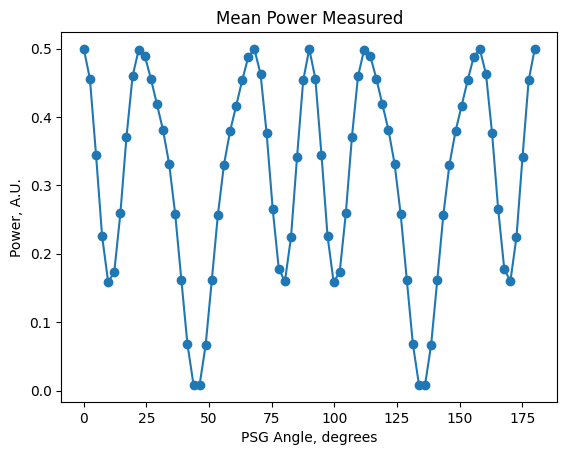

In [41]:
mean_power = np.mean(np.asarray(power_measured), axis=(1, 2))

plt.figure()
plt.plot(np.degrees(psg_angles), mean_power, marker='o')
plt.title('Mean Power Measured')
plt.xlabel('PSG Angle, degrees')
plt.ylabel('Power, A.U.')
plt.show()

Let's get a sense of what the data looks like if we have infinite resolution, hooray simulation!

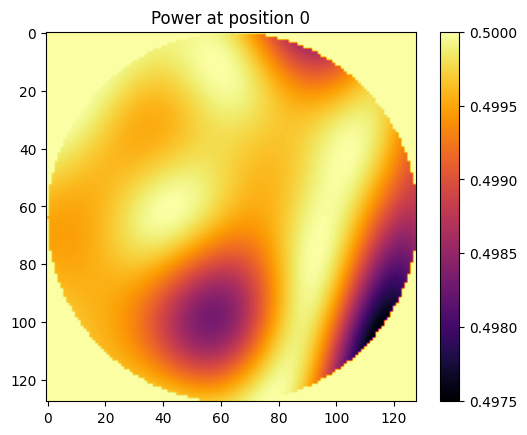

In [47]:
plt.figure()
plt.title('Power at position 0')
plt.imshow(power_measured[0], cmap='inferno')
plt.colorbar()
plt.show()

Now let us try to use `Katsu` to fit to these spatial variations.

## 3. Data Reduction with spatially-varying polarizers
What parameters require optimization? We have 
- $\mathbf{T}_{g}(\mathbf{r}, \mathbf{\theta})$, the minimum transmission of the PSG polarizer
- $\mathbf{\Phi}_{g}(\mathbf{r}, \mathbf{\theta})$, the angle of transmission of the PSG polarizer
- $\mathbf{\Delta}_{g}(\mathbf{r}, \mathbf{\theta})$, the retardance of the PSG retarder
- $\mathbf{\Psi}_{g}(\mathbf{r}, \mathbf{\theta})$, the fast axis of the PSG retarder
- $\mathbf{T}_{a}(\mathbf{r}, \mathbf{\theta})$, the minimum transmission of the PSA polarizer
- $\mathbf{\Phi}_{a}(\mathbf{r}, \mathbf{\theta})$, the angle of transmission of the PSA polarizer
- $\mathbf{\Delta}_{a}(\mathbf{r}, \mathbf{\theta})$, the retardance of the PSA retarder
- $\mathbf{\Psi}_{a}(\mathbf{r}, \mathbf{\theta})$, the fast axis of the PSA retarder
- $\theta_{p,g}$, the angular offset of the PSG polarizer
- $\theta_{r,g}$, the angular offset of the PSG retarder
- $\Theta_{r,g}$, the angular increment of the PSG retarder
- $\theta_{p,a}$, the angular offset of the PSA polarizer
- $\theta_{r,a}$, the angular offset of the PSA retarder
- $\Theta_{r,a}$, the angular increment of the PSA retarder

The bold quantities are of shape $N_{modes}$ and the remaining are individuals. We can pack the gradients by appending them to an array. In total, we need $8 \times N_{modes} + 6$ free parameters

In [6]:
# Set up the optics
coeffs_spatially_varying = np.random.random([8, len(basis)]) / 10
theta_pg = 0
theta_rg = 0
Theta_rg = np.radians(10)
theta_pa = np.radians(90)
theta_ra = 0
Theta_ra = np.radians(10)

NMEAS = 26

In [7]:
help(np.broadcast_to)

Help on _ArrayFunctionDispatcher in module numpy:

broadcast_to(array, shape, subok=False)
    Broadcast an array to a new shape.
    
    Parameters
    ----------
    array : array_like
        The array to broadcast.
    shape : tuple or int
        The shape of the desired array. A single integer ``i`` is interpreted
        as ``(i,)``.
    subok : bool, optional
        If True, then sub-classes will be passed-through, otherwise
        the returned array will be forced to be a base-class array (default).
    
    Returns
    -------
    broadcast : array
        A readonly view on the original array with the given shape. It is
        typically not contiguous. Furthermore, more than one element of a
        broadcasted array may refer to a single memory location.
    
    Raises
    ------
    ValueError
        If the array is not compatible with the new shape according to NumPy's
        broadcasting rules.
    
    See Also
    --------
    broadcast
    broadcast_arrays
    

### PSG Polarizer

In [8]:
trans_psg_pol = sum_of_2d_modes(basis, coeffs_spatially_varying[0])
trans_psg_pol -= trans_psg_pol.min()
angle_psg_pol = sum_of_2d_modes(basis, coeffs_spatially_varying[1])


psg_pol = linear_diattenuator(angle_psg_pol + theta_pg,
                              trans_psg_pol,
                              shape=[*angle_psg_pol.shape, NMEAS])

In [9]:
a = np.random.random([128,128])
b = np.random.random([128,128,1])
c = a * b
c.shape

(128, 128, 128)

In [10]:
isinstance(angle_psg_pol, np.ndarray)

True

### PSG Retarder

In [13]:
retar_psg_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[2])
angle_psg_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[3])
rotations = np.linspace(0, np.radians(180), NMEAS)

psg_wvp = linear_retarder(angle_psg_wvp + rotations,
                          retar_psg_wvp,
                          shape=[*angle_psg_wvp.shape, NMEAS])
plot_square(psg_wvp[:,:,0], n=4)

ValueError: operands could not be broadcast together with shapes (128,128) (26,) 

### PSA Retarder

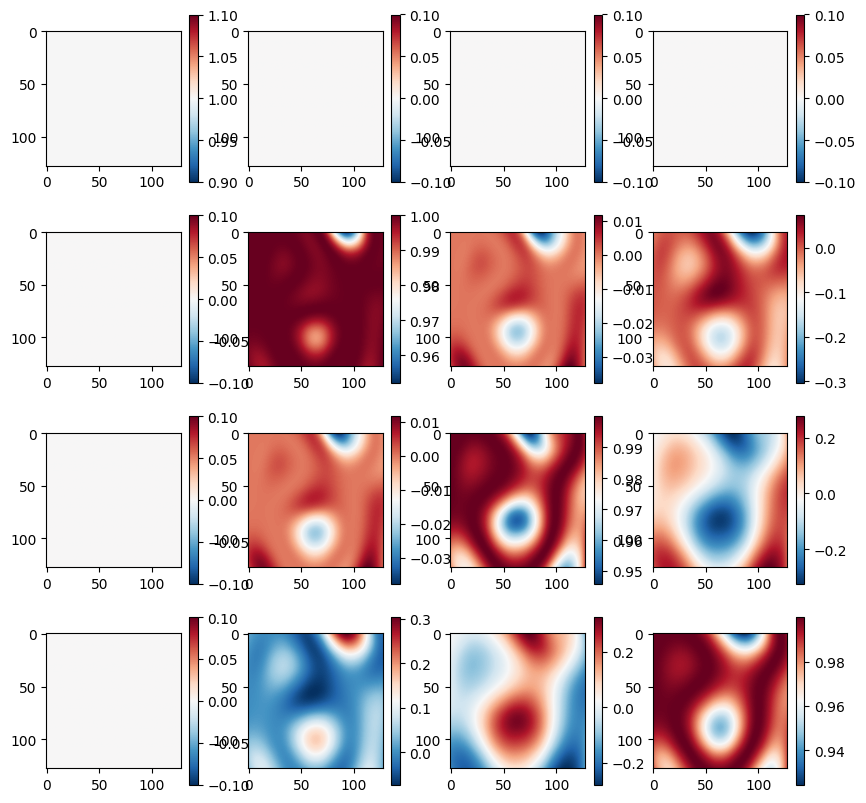

In [ ]:
retar_psa_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[4])
angle_psa_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[5])

psa_wvp = linear_retarder(angle_psa_wvp, retar_psa_wvp, shape=angle_psg_wvp.shape)
plot_square(psa_wvp, n=4)

### PSA Polarizer

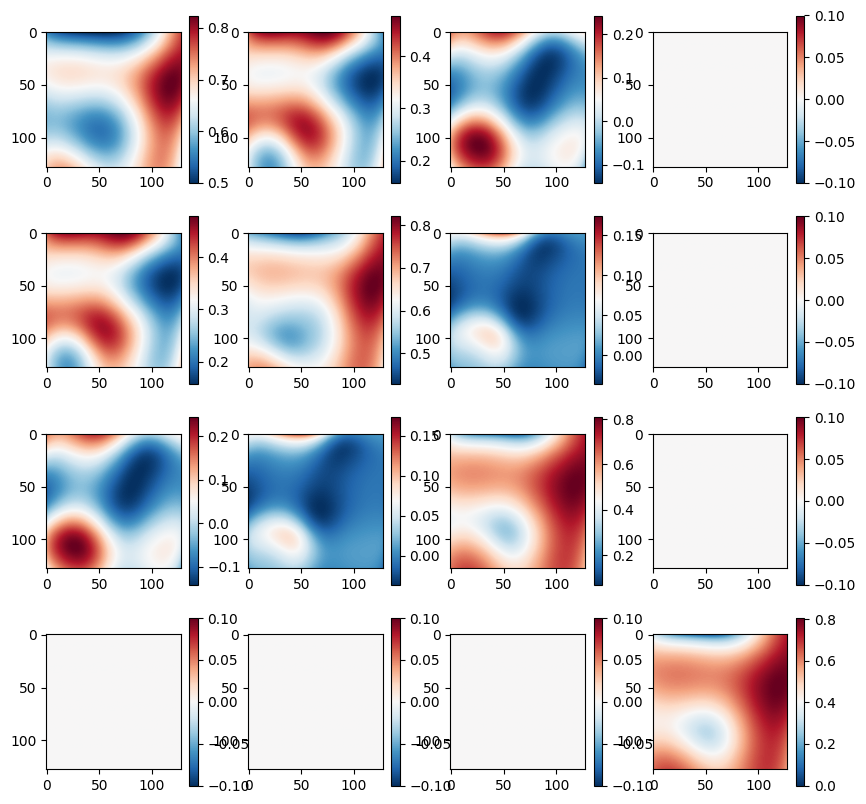

In [ ]:
trans_psa_pol = sum_of_2d_modes(basis, coeffs_spatially_varying[6])
trans_psa_pol -= trans_psa_pol.min()
angle_psa_pol = sum_of_2d_modes(basis, coeffs_spatially_varying[7])

psa_pol = linear_diattenuator(angle_psa_pol, trans_psa_pol, shape=angle_psa_pol.shape)
plot_square(psa_pol, n=4)

### The Forward Model